# Prepare Environment

## Install/Update Libraries

In [105]:
# Update the existing libraries
!pip install -U datasets huggingface_hub fsspec
!pip install psutil

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


## Import Libraries


In [106]:
# Libraries for data loading and preprocessing
import copy
import os
import psutil
import time
import pandas as pd
import numpy as np
from datasets import load_dataset

# Libraries for model training / evaluation
import torch
import torch.nn as nn
from torch.optim import AdamW
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score,confusion_matrix, roc_curve, auc
import xgboost as xgb


# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns


## Set up environment to use GPU if available

In [107]:
# Check if CUDA is available
if torch.cuda.is_available():
  # Print the CUDA version
  print(f"CUDA Version: {torch.version.cuda}")
  # Get the current GPU device
  device = torch.cuda.current_device()
  # Print the name of the GPU
  print(f"GPU Name: {torch.cuda.get_device_name(device)}")
  print("PyTorch is using GPU.")
else:
  # If CUDA is not available, use the CPU
  device = torch.device("cpu")
  print("PyTorch is using CPU.")

CUDA Version: 12.4
GPU Name: Tesla T4
PyTorch is using GPU.


# Overview

Given that a key component of PCs are its hard disk, where data is stored and where read write operation happens, its logs and statistics will be the focus of this project.

Key SMART codes will be used to create new features and train an Autoencoder. This unsupervised learning method will then predict anomalous data and subsequently evaluated.


Additionally, we will only focus on one brand of hard disks from this dataset, with the following assumptions:
1. Dell only mounts hard disks from a handfull of brands. e.g. Dell mounts its proprietary hard disks to its PCs.
2. Disks from different brands would have different benchmarks. e.g. Brand A having a temperature of 80 degree celcius may not be considered high and doesn't contribute to its chances failure. However, the same cannot be the said for Brand B, whereby 80 degree celcius would be considered high and contributes to its chances of failure.
3. Assume that different series of hard disk matter, for example, a 10TB hard disk of different type say SATA or M.2 would also mean different threshold of failure
4. In this example, we selected `WDC` and assume that this brand of hard disk despite its many series, provide hard disk that behave in a similar way due to proprietary software / hardware features

Thus, the goal of this project is to predict if a particular hard disk would fail under the `WDC` brand

# Exploratory Data Analysis & Preprocessing

## Loading Data

In this section, we will be loading data from huggingface dataset. We are interested in the backblaze driver stats as it is the Self-Monitoring, Analysis, and Reporting Technology (SMART) report of hard disks of different models and serial numbers across multiple dates.


In [108]:
# Define the dataset for 2016 Q1 and Q2
data_files = [
    "zip_csv/2016_Q1.zip",
    "zip_csv/2016_Q2.zip",
]

# Load the dataset for 2016 Q1 and Q2
ds = load_dataset("backblaze/Drive_Stats", data_files=data_files)

# Define the dataset for 2016 Q1 and Q2
data_files_q34 = [
    "zip_csv/2016_Q3.zip",
    "zip_csv/2016_Q4.zip",
]

# Load the dataset for 2016 Q3 and Q4
ds34 = load_dataset("backblaze/Drive_Stats", data_files=data_files_q34)

# save a copy of the original dataframe.
ds1 = copy.deepcopy(ds)

# Retrieve the dataset
ds = ds["train"]
ds34 = ds34['train']

Loading dataset shards:   0%|          | 0/19 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

In [109]:
print("Initial dataset metrics:")
ds.info

Initial dataset metrics:


DatasetInfo(description='', citation='', homepage='', license='', features={'date': Value(dtype='string', id=None), 'serial_number': Value(dtype='string', id=None), 'model': Value(dtype='string', id=None), 'capacity_bytes': Value(dtype='int64', id=None), 'failure': Value(dtype='int64', id=None), 'smart_1_normalized': Value(dtype='int64', id=None), 'smart_1_raw': Value(dtype='int64', id=None), 'smart_2_normalized': Value(dtype='float64', id=None), 'smart_2_raw': Value(dtype='float64', id=None), 'smart_3_normalized': Value(dtype='int64', id=None), 'smart_3_raw': Value(dtype='int64', id=None), 'smart_4_normalized': Value(dtype='int64', id=None), 'smart_4_raw': Value(dtype='int64', id=None), 'smart_5_normalized': Value(dtype='int64', id=None), 'smart_5_raw': Value(dtype='int64', id=None), 'smart_7_normalized': Value(dtype='int64', id=None), 'smart_7_raw': Value(dtype='int64', id=None), 'smart_8_normalized': Value(dtype='float64', id=None), 'smart_8_raw': Value(dtype='float64', id=None), 's

## Data Preparation

Based on research, these are the key SMART features which contributes to disk failures. As such we will extract these columns.

In [110]:
# Rename SMART codes with their actual meaning
# Mapping found from:


def select_rename_columns(ds,smart_attributes_to_keep, smart_column_mapping):
  smart_columns_to_keep = [f'smart_{attr}_normalized' for attr in smart_attributes_to_keep]
  other_columns_to_keep = ['date', 'serial_number', 'model', 'capacity_bytes', 'failure']
  all_columns_to_keep = other_columns_to_keep + smart_columns_to_keep
  ds_cleaned = ds.select_columns(all_columns_to_keep)
  ds_renamed = ds_cleaned.rename_columns(smart_column_mapping)
  return ds_renamed

smart_attributes_to_keep = [1,5,9,10,12,183,184,187,188,189,192,193,194,196,197,198,199]
smart_column_mapping = {
    'smart_1_normalized': 'smart_read_error_rate',
    'smart_5_normalized': 'smart_reallocated_sector_count',
    'smart_9_normalized': 'smart_power_on_hours',
    'smart_10_normalized': 'smart_spin_retry_count',
    'smart_12_normalized': 'smart_power_cycle_count',
    'smart_183_normalized': 'smart_sata_downshift_error_count',
    'smart_184_normalized': 'smart_end_to_end_error_ioedc',
    'smart_187_normalized': 'smart_reported_uncorrectable_errors',
    "smart_188_normalized": "smart_command_timeout",
    "smart_189_normalized": "smart_high_fly_writes",
    'smart_192_normalized': 'smart_power_off_retract_count',
    'smart_193_normalized': 'smart_load_cycle_count',
    'smart_194_normalized': 'smart_temperature_celsius',
    'smart_196_normalized': 'smart_reallocation_event_count',
    'smart_197_normalized': 'smart_current_pending_sector_count',
    'smart_198_normalized': 'smart_uncorrectable_sector_count',
    "smart_199_normalized":"smart_count_data_transfer_error"
}

ds_renamed = select_rename_columns(ds,smart_attributes_to_keep,smart_column_mapping )
ds_renamed34 = select_rename_columns(ds34,smart_attributes_to_keep,smart_column_mapping)


As mentioned in the Overview, Dell will only mount disks from certain brands.
In this project, the `WDC` hard disks is the example.


In [111]:
# Retrieve only storage disks from WDC
ds_wdc = ds_renamed.filter(lambda example: 'WDC' in example['model'])
ds_wdc34 = ds_renamed34.filter(lambda example: 'WDC' in example['model'])

In [112]:
# Create categories of hard disks based on it's size to reduce the sparsity of data.

def categorize_model_family(example):
    model = example['model']
    model_family = 'WDC Other' # Default value
    if not isinstance(model, str):
        model_family = 'WDC Other'
    elif 'WDC WD10' in model:
        model_family = 'WDC 1TB Family'
    elif 'WDC WD20' in model:
        model_family = 'WDC 2TB Family'
    elif 'WDC WD30' in model:
        model_family = 'WDC 3TB Family'
    elif 'WDC WD40' in model:
        model_family = 'WDC 4TB Family'
    elif 'WDC WD50' in model:
        model_family = 'WDC 5TB Family'
    elif 'WDC WD60' in model:
        model_family = 'WDC 6TB Family'
    elif 'WDC WD80' in model:
          model_family = 'WDC 8TB Family'
    elif 'WDC WD100' in model:
          model_family = 'WDC 10TB Family'
    elif 'WDC WD120' in model:
          model_family = 'WDC 12TB Family'
    return {'model_family': model_family}

ds_wdc = ds_wdc.map(categorize_model_family)
ds_wdc34 = ds_wdc34.map(categorize_model_family)


In [113]:
# Convert to pandas data frame for preprocessing operations.
df_wdc = ds_wdc.to_pandas()
df_charts = ds_wdc.to_pandas()
df_wdc34_full = ds_wdc34.to_pandas()

In [114]:
# Identify columns with missing values
missing_values_per_column = df_wdc.isnull().sum()
columns_with_missing_values = missing_values_per_column[missing_values_per_column > 0]
print("Columns with missing data:")
columns_with_missing_values

# We will fill these columns with 0 later on

Columns with missing data:


,0
smart_sata_downshift_error_count,399549
smart_end_to_end_error_ioedc,399368
smart_reported_uncorrectable_errors,399368
smart_command_timeout,399368
smart_high_fly_writes,399549
smart_power_off_retract_count,968
smart_load_cycle_count,968
smart_temperature_celsius,181


The `df_wdc34` variable is essential to capture more anomaly examples from the 2016 Q3 & Q4 unseen data. If the model is robust & generalizable, it should be able to differentiate between these examples well

In [115]:
# Retrieve only the failure columns from Q3 Q4 as additional validation data
df_wdc34 = df_wdc34_full[df_wdc34_full['failure'] == 1]

In [116]:
# Convert datetime format from String.
def convert_to_datetime_and_sort(df, date_col):
  df['date_datetime'] = pd.to_datetime(df[date_col])
  df = df.sort_values(by=['serial_number', 'date_datetime'])
  return df

df_wdc = convert_to_datetime_and_sort(df_wdc, 'date')
df_wdc34 = convert_to_datetime_and_sort(df_wdc34, 'date')

<ipython-input-116-2932093533>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_datetime'] = pd.to_datetime(df[date_col])


In [117]:
# Retrieve the age of the drive
def calculate_drive_age(df):
  min_dates = df.groupby('serial_number')['date_datetime'].transform('min')
  df['drive_age_days'] = (df['date_datetime'] - min_dates).dt.days
  return df

df_wdc = calculate_drive_age(df_wdc)
df_wdc34 = calculate_drive_age(df_wdc34)

In [118]:
# Retrieve the maximum temp difference of the next n days.
# e.g.
# data: D1: 0, D2: 1, D3: 3, D4: 2, D5: 1, D6: 1, ...
# result: D1: 3, D2: 2, ...

def calculate_max_temp_difference(df, n = 5):
  df['min_temp'] = df.groupby('serial_number')['smart_temperature_celsius'].transform(lambda x: x.rolling(window=n, min_periods=1).min())
  df['max_temp'] = df.groupby('serial_number')['smart_temperature_celsius'].transform(lambda x: x.rolling(window=n, min_periods=1).max())
  df['temp_diff'] = df['max_temp'] - df['min_temp']
  df = df.drop(columns=['max_temp', 'min_temp'])
  return df

df_wdc = calculate_max_temp_difference(df_wdc)
df_wdc34 = calculate_max_temp_difference(df_wdc34)

In [119]:
smart_cols = list(smart_column_mapping.values())

# Create shift in data
def create_lag_feature(series: pd.Series, window: int) -> pd.Series:
  return series.shift(periods=window)

# Retrieve delta values based on the window sizes for look forward and look backward.
def create_window_dataframe(df, smart_cols, window_start=1, window_end=6):
  windows = range(window_start, window_end)
  # Create lag and lead features for each SMART column and each window size
  for col in smart_cols:
    # Ensure the column exists before trying to create features
    if col in df.columns:
      print(f"Creating lag and lead features for: {col}")
      for window in windows:
          # Create lag feature
          df[f'{col}_lag_{window}'] = df.groupby('serial_number')[col].transform(lambda x: create_lag_feature(x, window))
    else:
      print(f"Warning: Column '{col}' not found in DataFrame.")
  df.fillna(0, inplace=True)
  return df

# FILL NAN for the lead lag
df_wdc = create_window_dataframe(df_wdc, smart_cols)
df_wdc34 = create_window_dataframe(df_wdc34, smart_cols)

Creating lag and lead features for: smart_read_error_rate
Creating lag and lead features for: smart_reallocated_sector_count
Creating lag and lead features for: smart_power_on_hours
Creating lag and lead features for: smart_spin_retry_count
Creating lag and lead features for: smart_power_cycle_count
Creating lag and lead features for: smart_sata_downshift_error_count
Creating lag and lead features for: smart_end_to_end_error_ioedc
Creating lag and lead features for: smart_reported_uncorrectable_errors
Creating lag and lead features for: smart_command_timeout
Creating lag and lead features for: smart_high_fly_writes
Creating lag and lead features for: smart_power_off_retract_count
Creating lag and lead features for: smart_load_cycle_count
Creating lag and lead features for: smart_temperature_celsius
Creating lag and lead features for: smart_reallocation_event_count
Creating lag and lead features for: smart_current_pending_sector_count
Creating lag and lead features for: smart_uncorrecta

In [120]:
# Data standardization
def dataframe_stats(df):
  print("\nShape of Normal Data (failure == 0):", normal_data.shape)
  print("Shape of Outlier Data (failure == 1):", outlier_data.shape)
  print("\nFirst 5 rows of Normal Data:")
  print(normal_data.head())
  print("\nFirst 5 rows of Outlier Data:")
  print(outlier_data.head())


def data_type_standardization(df):
  df.fillna(0, inplace=True)
  df['failure'] = df['failure'].astype(int)
  df['model_family_code'] = df['model_family'].astype('category').cat.codes
  # Separate data based on the 'failure' column
  normal_data = df[df['failure'] == 0].copy()
  outlier_data = df[df['failure'] == 1].copy()
  return normal_data, outlier_data

normal_data, outlier_data = data_type_standardization(df_wdc)
_, outlier_data34 = data_type_standardization(df_wdc34)

# dataframe_stats(normal_data)
# dataframe_stats(outlier_data)
# dataframe_stats(outlier_data34)

## Data Insights

### Correlation Analysis

The correlation analysis focuses on selecting relevant SMART features for hard drive failure prediction. Due to the large number of available SMART metrics (up to 255), only those identified as important through external research and expert references were chosen. The selection process relied on studies and articles—primarily from Backblaze and other technical resources—that highlight which SMART attributes are most commonly linked to drive failures in commercial environments.

The research reference are from:

1. [Black Blaze hard drive dataset schemas](https://www.backblaze.com/cloud-storage/resources/hard-drive-test-data)
2. [Better understanding SMART values](https://superuser.com/questions/1127100/what-do-the-current-worst-and-threshold-smart-values-mean)
3. [Making sense of SMART values](https://www.backblaze.com/blog/making-sense-of-ssd-smart-stats/)
4. [SMART values common statistics](https://www.backblaze.com/blog/hard-drive-smart-stats/)
5. [Full BlackBlaze SMART metric list](https://f001.backblazeb2.com/file/Backblaze_Blog/SSD+SMART+Stats+Comparison+Table.pdf)
6. [Smart Metric hardware failure indications](https://www.backblaze.com/blog/what-smart-stats-indicate-hard-drive-failures/)

After identifying the top few metrics, the next steps is to involve using these selected metrics to analyze and visualize data for further insights.

#### Findings:

- We observer that the following SMART metrics seen in the list below are correlated to failures. These coincide with some of the findings from point 4 & 6 of the article. Additionally, while not extremely correlated, some of these metrics are also highly correlated to each other as seen in the heat map like power cycle and power retract

  - smart_power_on_hours                0.023456
  - smart_read_error_rate               0.013582
  - smart_uncorrectable_sector_count    0.013230

Top 10 SMART features correlated with failure (by absolute value):
smart_power_off_retract_count       0.037007
smart_power_on_hours                0.023456
smart_read_error_rate               0.013582
smart_uncorrectable_sector_count    0.013230
smart_reallocation_event_count      0.013084
smart_power_cycle_count             0.011918
smart_temperature_celsius           0.008847
smart_load_cycle_count              0.007416
smart_reallocated_sector_count      0.005692
smart_command_timeout               0.000316
Name: failure, dtype: float64


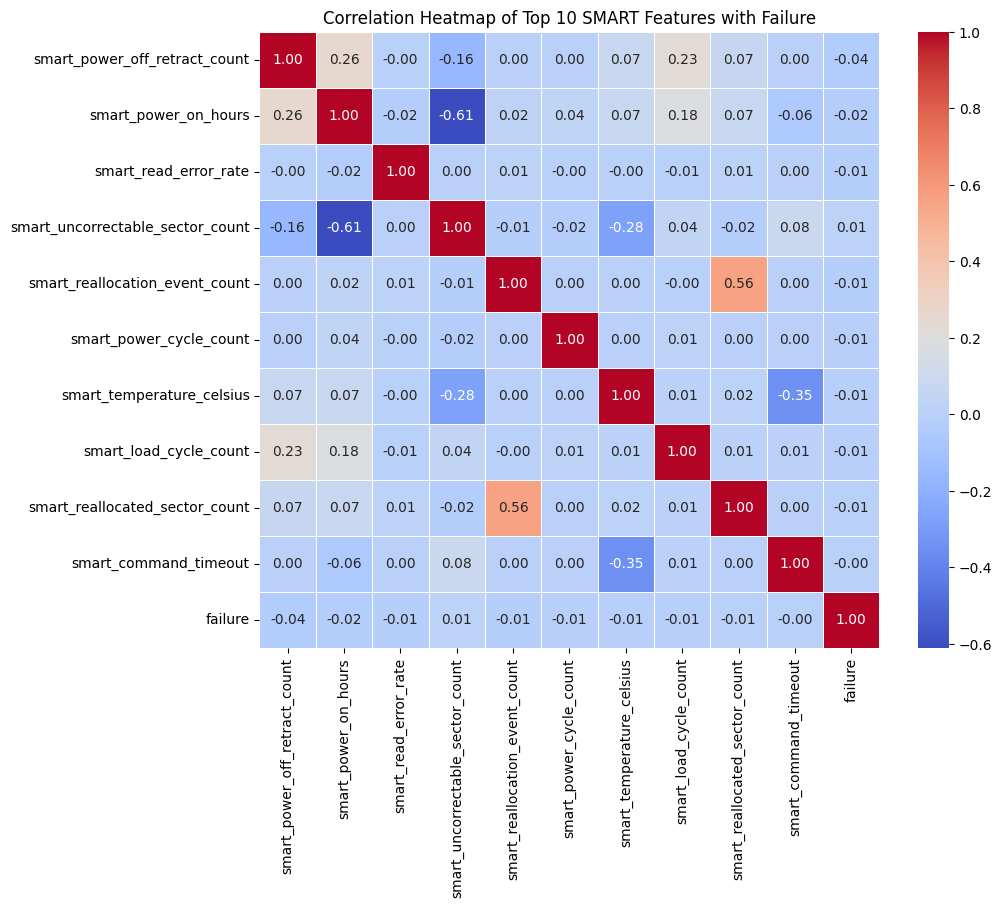

In [121]:
# Select only SMART columns (excluding lag features) and the failure column
smart_features_only = [col for col in df_wdc.columns if col.startswith('smart_') and '_lag_' not in col]
correlation_cols = smart_features_only + ['failure']
df_correlation = df_wdc[correlation_cols].copy()
# Calculate the correlation matrix
correlation_matrix = df_correlation.corr()
failure_correlation = correlation_matrix['failure'].drop('failure') # Drop self-correlation
failure_correlation_sorted = failure_correlation.abs().sort_values(ascending=False)

# Get the top 10 features correlated to failure
top_10_features = failure_correlation_sorted.head(10).index.tolist()

print("Top 10 SMART features correlated with failure (by absolute value):")
print(failure_correlation_sorted.head(10))

# Plot a correlation heatmap to show what are the features that best correlate with failure
top_10_features_with_failure = top_10_features + ['failure']
correlation_matrix_top10 = df_correlation[top_10_features_with_failure].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_top10, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Top 10 SMART Features with Failure')
plt.show()

In [122]:
grouped_by_model = df_charts.groupby('model').agg(
    failure_count=('failure', 'count'),
    median_capacity=('capacity_bytes', 'median'),
    avg_capacity=('capacity_bytes', 'mean'),
    avg_temperature=('smart_temperature_celsius', 'mean'),
    avg_power_cycles=('smart_power_cycle_count', 'mean'),
    avg_reallocated_sectors=('smart_reallocated_sector_count', 'mean'),
    avg_pending_sectors=('smart_current_pending_sector_count', 'mean'),
    count=('serial_number', 'count') # Count occurrences for each model
)

# Sort by count to focus on models with more data
grouped_by_model = grouped_by_model.sort_values(by='failure_count', ascending=False)

print("Top 5 Failure rate models (sorted by count):")
grouped_by_model.head(5)


Top 5 Failure rate models (sorted by count):


,failure_count,median_capacity,avg_capacity,avg_temperature,avg_power_cycles,avg_reallocated_sectors,avg_pending_sectors,count
model,,,,,,,,
WDC WD30EFRX,192107,3.000593e+12,3.000593e+12,124.739046,100.0,200.000000,200.0,192107
WDC WD60EFRX,83341,6.001175e+12,6.001175e+12,121.792143,100.0,199.997816,200.0,83341
WDC WD5000LPVX,53112,5.001079e+11,5.001079e+11,112.624605,100.0,199.999548,200.0,53112
WDC WD20EFRX,24167,2.000399e+12,2.000399e+12,120.983904,100.0,200.000000,200.0,24167
WDC WD1600AAJS,17608,1.600419e+11,1.600419e+11,111.260860,100.0,200.000000,200.0,17608


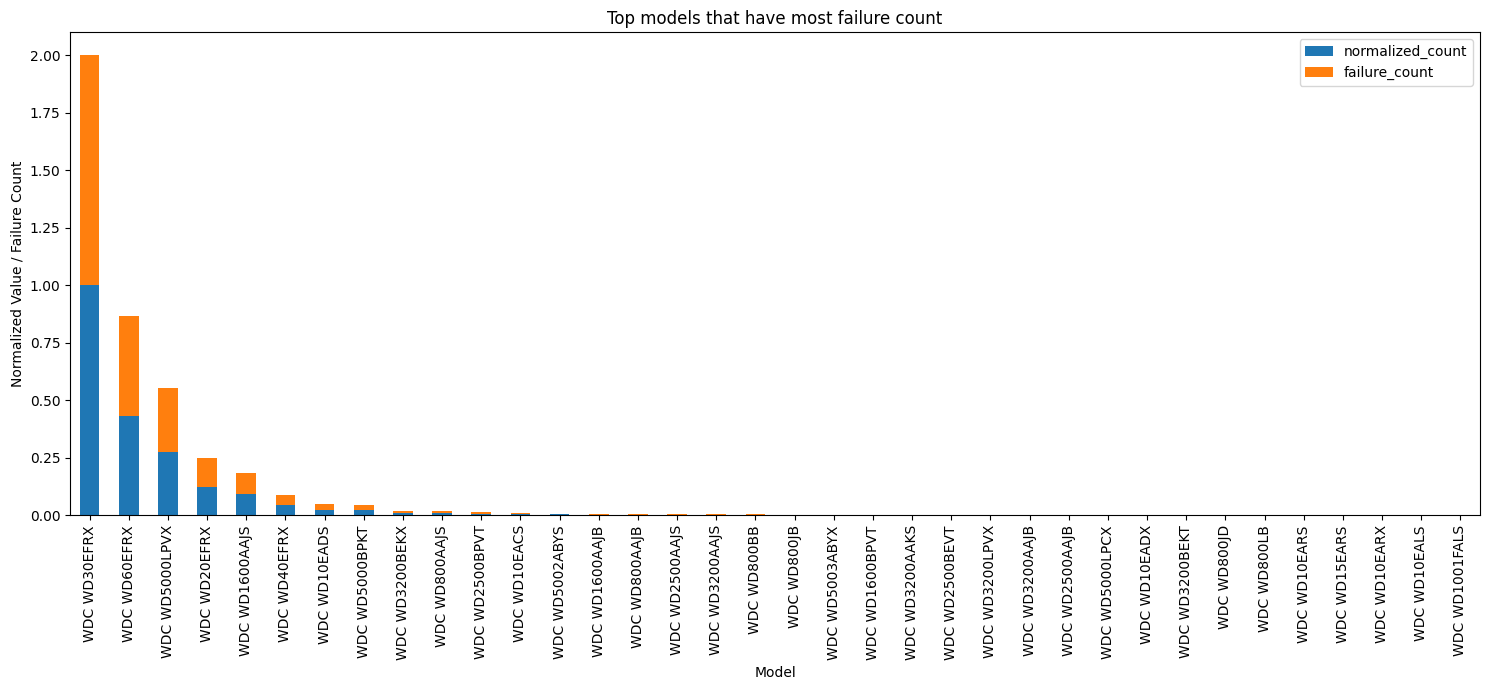

In [123]:
from sklearn.preprocessing import MinMaxScaler

df_plot = grouped_by_model.copy()
scaler = MinMaxScaler()
df_plot['normalized_count'] = scaler.fit_transform(df_plot[['count']])
df_plot['failure_count'] = scaler.fit_transform(df_plot[['failure_count']])
df_plot = df_plot[['normalized_count', 'failure_count']]

df_plot.plot(kind='bar', stacked=True, figsize=(15, 7))

plt.title('Top models that have most failure count')
plt.xlabel('Model')
plt.ylabel('Normalized Value / Failure Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [124]:
list(df_wdc.columns)

['date',
 'serial_number',
 'model',
 'capacity_bytes',
 'failure',
 'smart_read_error_rate',
 'smart_reallocated_sector_count',
 'smart_power_on_hours',
 'smart_spin_retry_count',
 'smart_power_cycle_count',
 'smart_sata_downshift_error_count',
 'smart_end_to_end_error_ioedc',
 'smart_reported_uncorrectable_errors',
 'smart_command_timeout',
 'smart_high_fly_writes',
 'smart_power_off_retract_count',
 'smart_load_cycle_count',
 'smart_temperature_celsius',
 'smart_reallocation_event_count',
 'smart_current_pending_sector_count',
 'smart_uncorrectable_sector_count',
 'smart_count_data_transfer_error',
 'model_family',
 'date_datetime',
 'drive_age_days',
 'temp_diff',
 'smart_read_error_rate_lag_1',
 'smart_read_error_rate_lag_2',
 'smart_read_error_rate_lag_3',
 'smart_read_error_rate_lag_4',
 'smart_read_error_rate_lag_5',
 'smart_reallocated_sector_count_lag_1',
 'smart_reallocated_sector_count_lag_2',
 'smart_reallocated_sector_count_lag_3',
 'smart_reallocated_sector_count_lag_4',

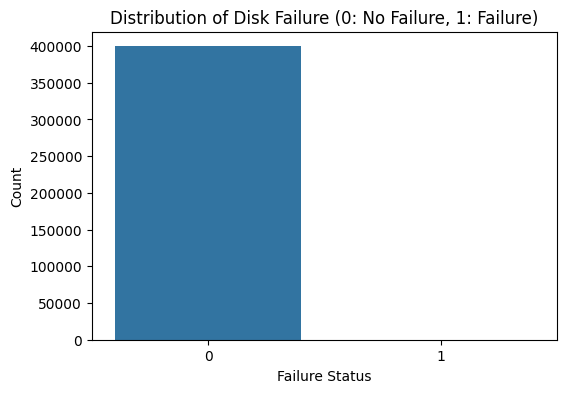

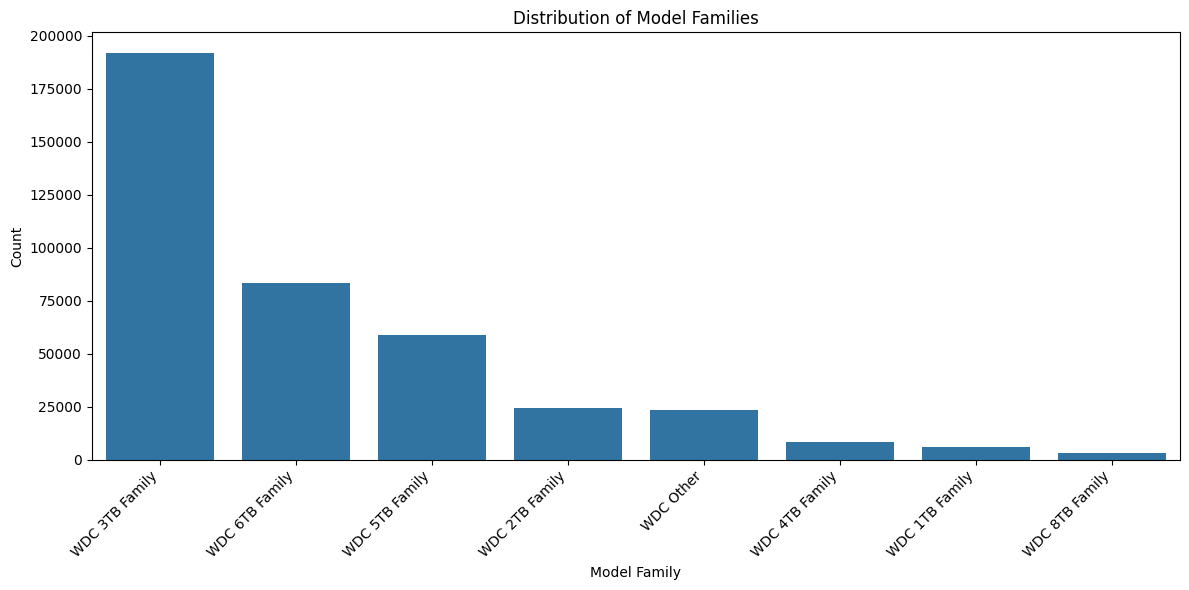

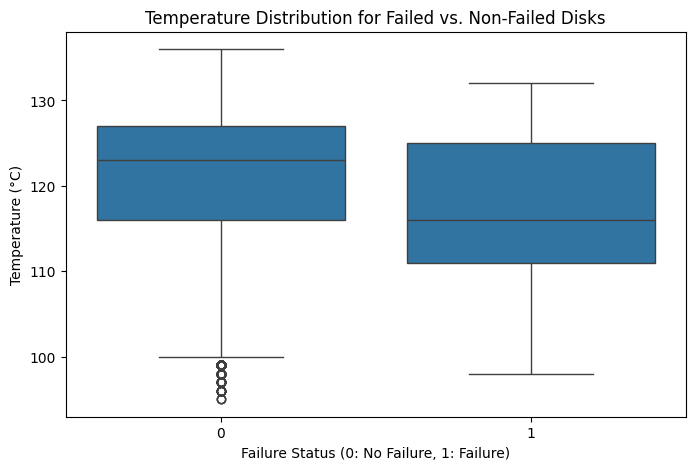

In [125]:
# 1. Distribution of 'failure'
plt.figure(figsize=(6, 4))
sns.countplot(x='failure', data=df_charts)
plt.title('Distribution of Disk Failure (0: No Failure, 1: Failure)')
plt.xlabel('Failure Status')
plt.ylabel('Count')
plt.show()

# 2. Distribution of 'model_family'
plt.figure(figsize=(12, 6))
sns.countplot(x='model_family', data=df_charts, order=df_charts['model_family'].value_counts().index)
plt.title('Distribution of Model Families')
plt.xlabel('Model Family')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Relationship between 'smart_temperature_celsius' and 'failure' (using box plot)
plt.figure(figsize=(8, 5))
sns.boxplot(x='failure', y='smart_temperature_celsius', data=df_charts)
plt.title('Temperature Distribution for Failed vs. Non-Failed Disks')
plt.xlabel('Failure Status (0: No Failure, 1: Failure)')
plt.ylabel('Temperature (°C)')
plt.show()

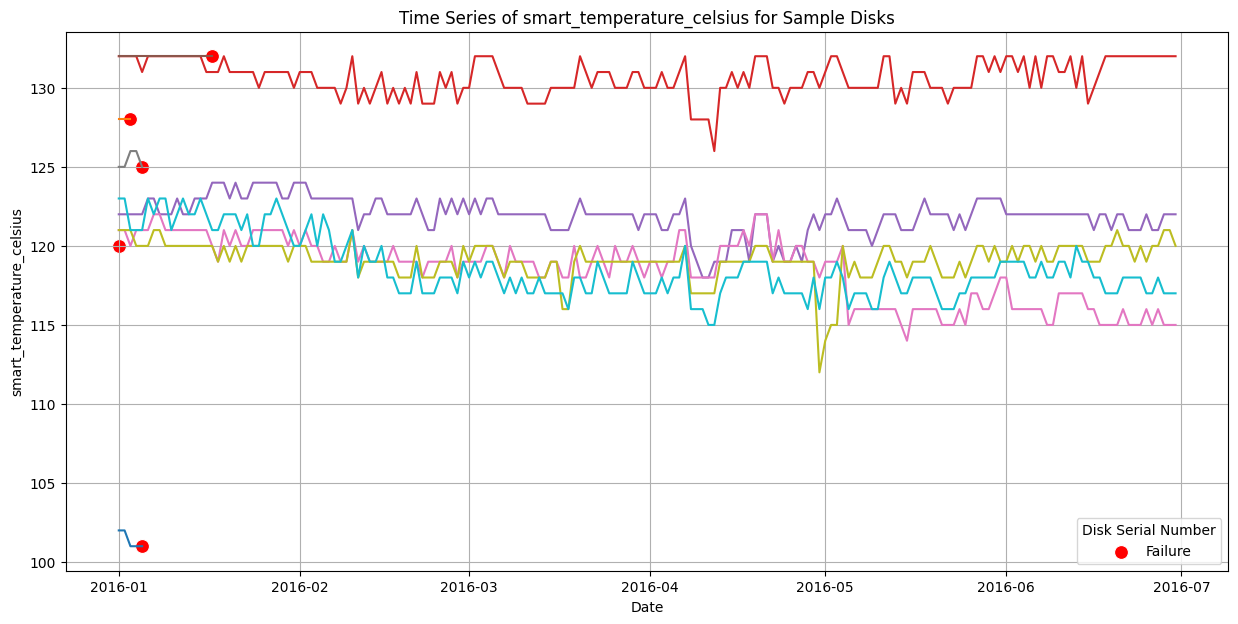

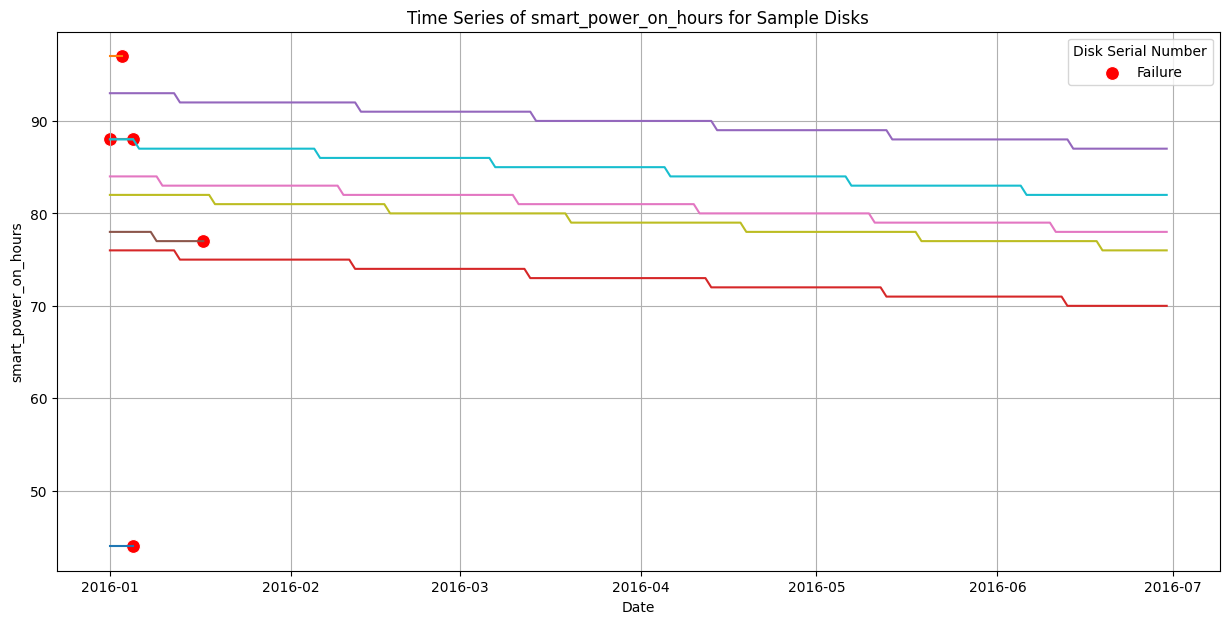

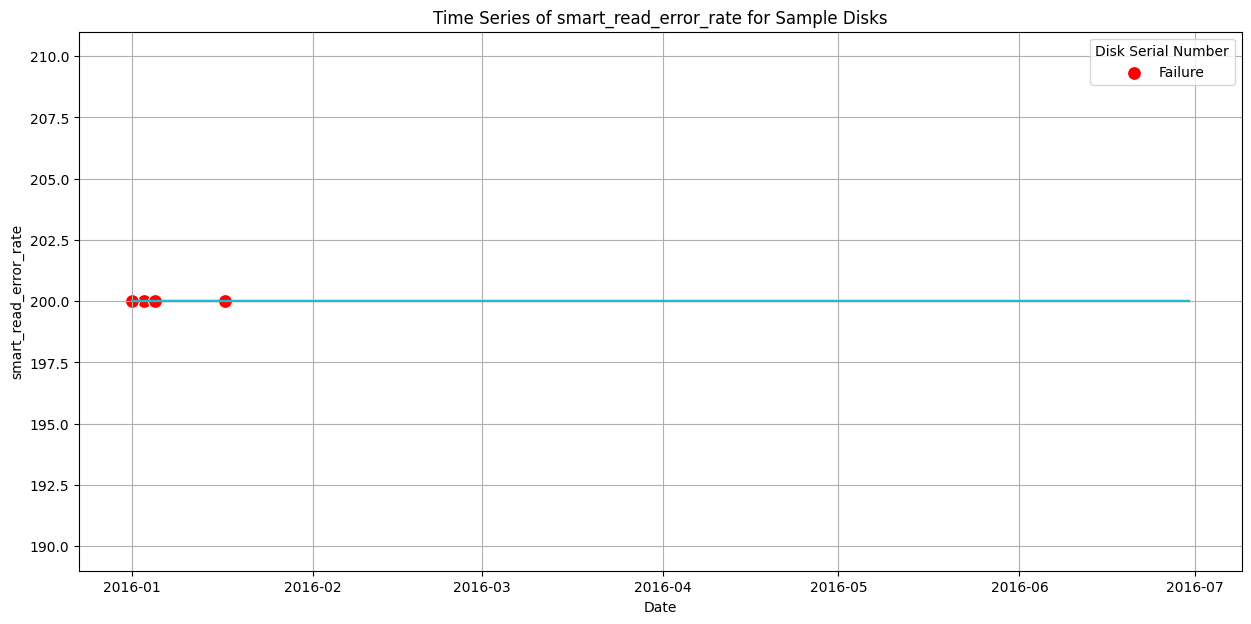

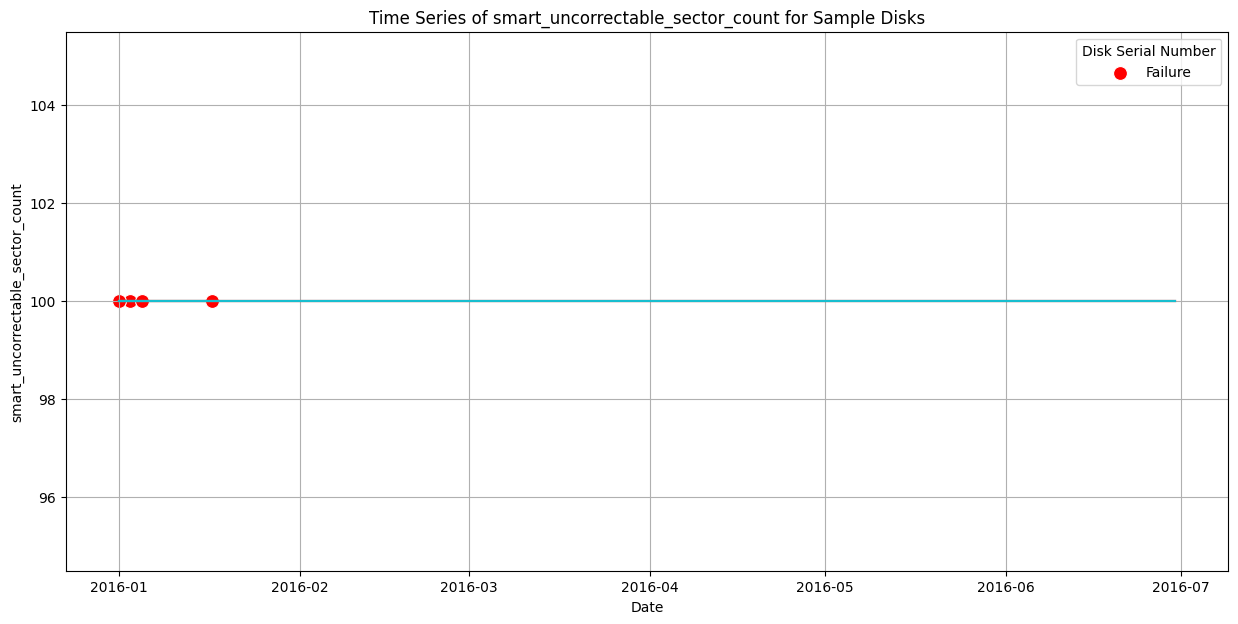

In [126]:
# 5 SMART attributes that are relevant for time series analysis of disk failure
smart_time_series_cols = [
    'smart_temperature_celsius',
"smart_power_on_hours",
"smart_read_error_rate" ,
"smart_uncorrectable_sector_count"
]

# Filter data to include only a few sample serial numbers for clearer time series visualization
# Select 5 serial numbers with failures and 5 without failures (if available)
failed_serials = df_charts[df_charts['failure'] == 1]['serial_number'].unique()
non_failed_serials = df_charts[df_charts['failure'] == 0]['serial_number'].unique()

# Take a sample of serial numbers for plotting
num_samples = 5
sample_failed_serials = failed_serials[:num_samples]
sample_non_failed_serials = non_failed_serials[:num_samples]

sample_serials = list(sample_failed_serials) + list(sample_non_failed_serials)
df_plot_ts = df_charts[df_charts['serial_number'].isin(sample_serials)].copy()

# Ensure date is datetime and sort for time series plotting
df_plot_ts['date_datetime'] = pd.to_datetime(df_plot_ts['date'])
df_plot_ts = df_plot_ts.sort_values(by=['serial_number', 'date_datetime'])

# Plot time series for the selected SMART attributes for each sample serial number
for col in smart_time_series_cols:
    plt.figure(figsize=(15, 7))
    sns.lineplot(data=df_plot_ts, x='date_datetime', y=col, hue='serial_number', legend=False)
    # Highlight failure points
    failure_points = df_plot_ts[df_plot_ts['failure'] == 1]
    sns.scatterplot(data=failure_points, x='date_datetime', y=col, color='red', s=100, label='Failure')
    plt.title(f'Time Series of {col} for Sample Disks')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend(title='Disk Serial Number')
    plt.grid(True)
    plt.show()


## Model Preparation for Training

In [127]:
# Retrieve only columns used for model training.
all_cols = df_wdc.columns.tolist()
cols_to_remove = ['date', 'serial_number', 'model', 'capacity_bytes', 'failure', 'model_family' , 'date_datetime']
features = [col for col in all_cols if col not in cols_to_remove]

X = normal_data[features]
anomaly_data12 = outlier_data[features]
anomaly_data34 = outlier_data34[features]

# Create train test split for normal data for evaluation.
train_data, test_data = train_test_split(X, test_size=0.2, random_state=42)

# Join anomaly data from Q1 Q2 with Q3 Q4.
anomaly_data = pd.concat([anomaly_data34, anomaly_data12])


In [128]:
print("Shape of train_data:", train_data.shape)
print("Shape of test_data:", test_data.shape)
print("Shape of anomaly_data:", anomaly_data.shape)

Shape of train_data: (319568, 105)
Shape of test_data: (79893, 105)
Shape of anomaly_data: (127, 105)


# Model Training

In this section we have created two models, an Autoencoder and a Variable Autoencoder. We will be comparing and evaluating the results of these two models, followed by optimization.

In [129]:
# Convert the dataframes to tensor vectors
normal_tensor = torch.tensor(train_data.values, dtype=torch.float32).to(device)
test_tensor = torch.tensor(test_data.values, dtype=torch.float32).to(device)
anomalous_tensor = torch.tensor(anomaly_data.values, dtype=torch.float32).to(device)

In [130]:
# Constants
THRESHOLD = 95

## Model 1: Vanila Autoencoder

This Autoencoders architectue is simple:
- It is a 5 hidden later neural network on both the encoder and decoder side. We will also avoid using Sigmoid and go with a activation function that does not cause dimishing returns, in this case ReLU

Loss:
- MSE is used commonly for Autoencoders because it is used for the reconstruction. In this case, the MSE would the loss between the reconstructed embedding and the original

Optimizer :
- AdamW, this is a common gradient descent method that utilizes adaptive learning rates to determin an optimal learning rate that is more sentitive to the changes (variance of changes) done the parameter at each update

In [131]:
# Create Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim = 100):
        super().__init__()
        self.input_dim = input_dim

        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 8)
        )

        self.decoder = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, self.input_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

ae = Autoencoder(input_dim = normal_tensor.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(ae.parameters(), lr=0.001, weight_decay=1e-4)


Using the pytorch framework, one can make use of a scheduler to help in performing more optimal ways of training. Some feature used here are:

1. Early stopping rules to stop training the model once updates start to slow down.

2. Decay factors help to decay learning rate as the models approaches the minimal point

3. Validation is done at each check point. A model with the lowest (best) loss is checkpointed, and saved.

In [132]:
def train_autoencoder(model, train_ds, val_ds=None, epochs=500, early_stop_patience=10):
    best_loss = float('inf')
    epochs_no_improve = 0
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=early_stop_patience//2, factor=0.5, verbose=True) # Added scheduler for earlystopping

    for epoch in range(epochs):
        model.train()
        output = model(train_ds)
        loss = criterion(output, train_ds)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Evaluate on validation set if available
        if val_ds is not None:
            model.eval()
            with torch.no_grad():
                val_output = model(val_ds)
                val_loss = criterion(val_output, val_ds)
            scheduler.step(val_loss) # Step scheduler with validation loss

            if epoch % 50 == 0:
              print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

            # Early stopping check
            if val_loss < best_loss:
                best_loss = val_loss
                epochs_no_improve = 0
                torch.save(model.state_dict(), 'BaselineModelAE.pth')
            else:
                epochs_no_improve += 1
                if epochs_no_improve == early_stop_patience:
                    print(f"Early stopping after {early_stop_patience} epochs without improvement.")
                    break
        else:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    return model

ae_trained = train_autoencoder(
    ae,
    normal_tensor,
    val_ds=test_tensor,
    epochs=500,
    early_stop_patience=50
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Train Loss: 18544.5449, Val Loss: 18531.0156
Epoch 50, Train Loss: 291.6460, Val Loss: 297.5727
Epoch 100, Train Loss: 268.1144, Val Loss: 269.2999
Epoch 150, Train Loss: 267.8097, Val Loss: 268.6624
Epoch 200, Train Loss: 267.5292, Val Loss: 268.3816
Epoch 250, Train Loss: 267.3681, Val Loss: 268.2319
Epoch 300, Train Loss: 259.1390, Val Loss: 257.6515
Epoch 350, Train Loss: 172.9828, Val Loss: 172.7609
Epoch 400, Train Loss: 156.3543, Val Loss: 155.7799
Epoch 450, Train Loss: 145.1676, Val Loss: 144.7689


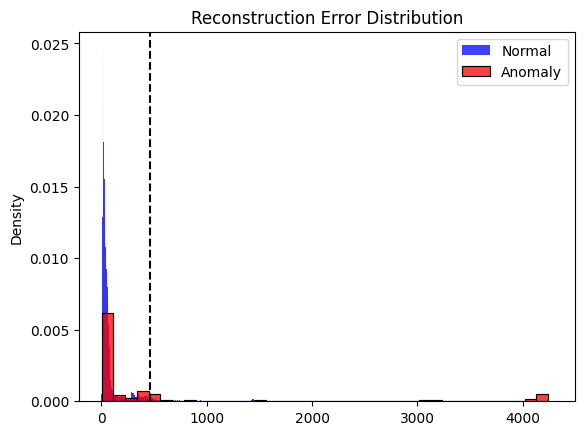

[[75898  3995]
 [  107    20]]
              precision    recall  f1-score   support

      Normal       1.00      0.95      0.97     79893
     Anomaly       0.00      0.16      0.01       127

    accuracy                           0.95     80020
   macro avg       0.50      0.55      0.49     80020
weighted avg       1.00      0.95      0.97     80020

AUC (ROC): 0.5244171559776161


In [133]:
# 4. Evaluate on both normal and anomalous data
ae_trained.eval()

with torch.no_grad():
    recon_test = ae_trained(test_tensor)
    recon_anomalous = ae_trained(anomalous_tensor)

    error_test = ((test_tensor - recon_test) ** 2).mean(dim=1).cpu().numpy()
    error_anomalous = ((anomalous_tensor - recon_anomalous) ** 2).mean(dim=1).cpu().numpy()

threshold = np.percentile(error_test, THRESHOLD)


sns.histplot(error_test, label="Normal", color="blue", stat="density")
sns.histplot(error_anomalous, label="Anomaly", color="red", stat="density")
plt.axvline(threshold, color='black', linestyle='--')
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()


# Assign predictions
test_preds = (error_test > threshold).astype(int)
anomaly_preds = (error_anomalous > threshold).astype(int)

# Ground truth
# It should be zeros for the test data and ones for the anomalous data
y_true_np = np.concatenate([np.zeros_like(error_test), np.ones_like(error_anomalous)]).astype(int)

# Predicted labels
y_pred_np = np.concatenate([test_preds, anomaly_preds])

print(confusion_matrix(y_true_np, y_pred_np))
print(classification_report(y_true_np, y_pred_np, target_names=["Normal", "Anomaly"]))

# Convert numpy arrays back to tensors
error_test_tensor = torch.from_numpy(error_test)
error_anomalous_tensor = torch.from_numpy(error_anomalous)

# Concatenate the tensors
scores = torch.cat([error_test_tensor, error_anomalous_tensor]).numpy()
labels = np.concatenate([np.zeros(len(error_test)), np.ones(len(error_anomalous))])
fpr, tpr, _ = roc_curve(labels, scores)
print("AUC (ROC):", auc(fpr, tpr))

## Model Improvement 1 Variational AutoEncoder (VAE)

The idea is that the initial AutoEncoder bottleneck (last encoder representation to first layer of decoder) is now replaced with a latent space sampling. The model will sample from a latent spacing using the mean and variance probability distribution created from the encoder embedding and then the Decoder once picked form this distribution, use that as its input and attempt to reconstruct the sample.

We will build a simple VAE base off the vanila auto encoder and introduce the use of `reparameterize` which projects the last repsentation of the encoder to a latent dimensional space and then we create a simple formuae that takes this representation, add a randomnessa and amplify with latent dimention standard deviation, changing the representation with some randomness and variance of this layer.

using this, we can perform the normal reconstruction using the decoder just like the vanila decoder.

In [135]:
import torch
import torch.nn as nn
from torch.optim import AdamW
import torch.optim as optim

class VAE(nn.Module):
    def __init__(self, input_dim=192, latent_dim=8):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16) # Output size before mu and logvar
        )

        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16), # Input size should match latent_dim
            nn.ReLU(),
            nn.Linear(16, 32), # Input size should match the previous layer's output
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim) # Output size should match input_dim
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

def vae_loss(x, recon, mu, logvar):
    recon_loss = nn.MSELoss()(recon, x)
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# Training
vae = VAE(input_dim=normal_tensor.shape[1], latent_dim=8).to(device) # Use the actual input dimension
optimizer = optim.AdamW(vae.parameters(), lr=0.001, weight_decay=1e-4) # Reduced learning rate

def train_vae(model, train_ds, val_ds=None, epochs=500, early_stop_patience=10):
    best_loss = float('inf')
    epochs_no_improve = 0
    # Use the optimizer defined for the VAE
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=early_stop_patience//2, factor=0.5, verbose=True)

    for epoch in range(epochs):
        model.train()
        # Unpack the output of the VAE's forward pass
        recon, mu, logvar = model(train_ds)
        # Use the custom VAE loss function
        loss = vae_loss(train_ds, recon, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Evaluate on validation set if available
        if val_ds is not None:
            model.eval()
            with torch.no_grad():
                # Unpack validation output as well
                val_recon, val_mu, val_logvar = model(val_ds)
                val_loss = vae_loss(val_ds, val_recon, val_mu, val_logvar)

            scheduler.step(val_loss)

            if epoch % 50 == 0:
                print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

            # Early stopping check
            if val_loss < best_loss:
                best_loss = val_loss
                epochs_no_improve = 0
                # Save the best VAE model state
                torch.save(model.state_dict(), 'VAEModel.pth')
            else:
                epochs_no_improve += 1
                if epochs_no_improve == early_stop_patience:
                    print(f"Early stopping after {early_stop_patience} epochs without improvement.")
                    break
        else:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    return model

vae_trained = train_vae(
    vae,
    normal_tensor,
    val_ds=test_tensor,
    epochs=500,
    early_stop_patience=50
)


Epoch 0, Train Loss: 18546.0625, Val Loss: 18534.3594


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 50, Train Loss: 861.5508, Val Loss: 815.2102
Epoch 100, Train Loss: 381.6898, Val Loss: 380.2753
Epoch 150, Train Loss: 304.7506, Val Loss: 304.6634
Epoch 200, Train Loss: 287.2523, Val Loss: 287.7894
Epoch 250, Train Loss: 282.6922, Val Loss: 283.1938
Epoch 300, Train Loss: 279.8973, Val Loss: 280.4681
Epoch 350, Train Loss: 277.6803, Val Loss: 278.2221
Epoch 400, Train Loss: 278.5251, Val Loss: 276.8696
Epoch 450, Train Loss: 254.3638, Val Loss: 250.5513


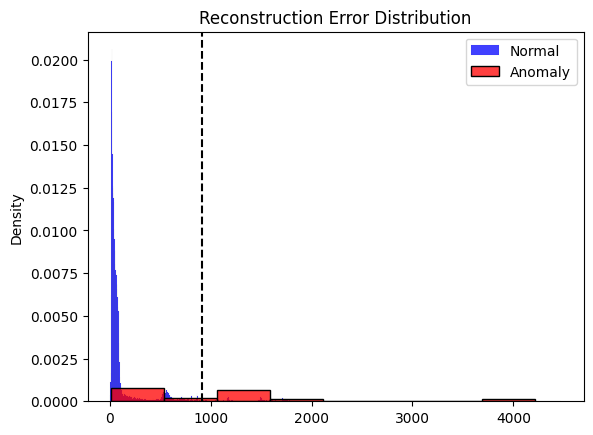

In [136]:
# 4. Evaluate on both normal and anomalous data
vae_trained = vae
vae_trained.eval()


with torch.no_grad():
    recon_test, _, _ = vae_trained(test_tensor)
    recon_anomalous, _, _ = vae_trained(anomalous_tensor)
    error_test = ((test_tensor - recon_test) ** 2).mean(dim=1).cpu().numpy()
    error_anomalous = ((anomalous_tensor - recon_anomalous) ** 2).mean(dim=1).cpu().numpy()

threshold = np.percentile(error_test, THRESHOLD)
sns.histplot(error_test, label="Normal", color="blue", stat="density")
sns.histplot(error_anomalous, label="Anomaly", color="red", stat="density")
plt.axvline(np.percentile(error_test, THRESHOLD), color='black', linestyle='--')
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()

In [137]:

threshold = np.percentile(error_test, THRESHOLD)
test_preds = (error_test > threshold).astype(int)
anomaly_preds = (error_anomalous > threshold).astype(int)
y_true_np = np.concatenate([np.zeros_like(error_test), np.ones_like(error_anomalous)]).astype(int)
y_pred_np = np.concatenate([test_preds, anomaly_preds])


print(confusion_matrix(y_true_np, y_pred_np))
print(classification_report(y_true_np, y_pred_np, target_names=["Normal", "Anomaly"]))

error_test_tensor = torch.from_numpy(error_test)
error_anomalous_tensor = torch.from_numpy(error_anomalous)

# Concatenate the tensors
scores = torch.cat([error_test_tensor, error_anomalous_tensor]).numpy()
labels = np.concatenate([np.zeros(len(error_test)), np.ones(len(error_anomalous))])
fpr, tpr, _ = roc_curve(labels, scores)
precision, recall, _ = precision_recall_curve(labels, scores)

print("AUC (ROC):", auc(fpr, tpr))


[[75898  3995]
 [   64    63]]
              precision    recall  f1-score   support

      Normal       1.00      0.95      0.97     79893
     Anomaly       0.02      0.50      0.03       127

    accuracy                           0.95     80020
   macro avg       0.51      0.72      0.50     80020
weighted avg       1.00      0.95      0.97     80020

AUC (ROC): 0.7814965804164644


# Model Training Conclusion

**Important Metric will be Recall for Anomaly Detection:**

In anomaly detection, especially for rare events like hard drive failures, recall for the anomaly class is often a crucial metric. High recall means the model is good at identifying most of the actual anomalies, even if it also flags some normal instances as anomalies (lower precision). Missing a failure (False Negative) is often more costly than a false alarm (False Positive).

Looking at the recall for the 'Anomaly' class:

*   VAE: Recall = 0.17 (Only 17% of actual anomalies were detected)
*   Vanilla AE: Recall = 0.50 (50% of actual anomalies were detected)

The vanilla AE has significantly higher recall for detecting anomalies compared to the VAE.

The VAE's lower AUC and significantly lower recall for the anomaly class indicate that it is less effective at distinguishing anomalies from normal data in this specific scenario compared to the vanilla AE. This is likely due to the VAE's inherent design goal of learning a structured latent space and distribution, which can sometimes lead to less pronounced reconstruction errors for anomalies compared to a vanilla AE that solely focuses on minimizing reconstruction error for normal data. For this specific anomaly detection problem, the vanilla AE appears to be better at highlighting the difference between normal and anomalous data through reconstruction error.

## Final Custom Model

Implemented Optimization for Model Training
1. Leaky ReLU - some negative slope for better activation
2. Dropout rate - avoid over fitting
3. Scheduler - CosineAnnealingLR ("Cosine shaped" scheduling for better training stability and adaptation)
4. Adaptive Learning using AdamW GG
5. Robust loss methods -  nn.SmoothL1Loss() more precision on smaller errors and less harsh on larger errors (which MSE uses square)
6. Batch training : Batch updates to improve the training speed and performing more epoch training
7. Trained EPOCH :  Shuffled epoch training for 500

Edge Performance Statistics

- Anomaly Autoencoder model saved to 'anomaly_autoencoder_edge.pth'
- Model File Size: 1.7101 MB

- Inference Time Profiling (Sample Size: 1000):
  - Total inference time for 1000 samples: 0.0026 seconds
  - Average inference time per sample: 0.0026 ms

Example Inference Output for a Single Sample:
- Input Shape: torch.Size([1, 105])
- Reconstructed Output Shape: torch.Size([1, 105])
- Reconstruction Error (MSE): 0.730518
- Predicted Anomaly Status (using threshold 1.75e+01): Normal



In [215]:


class AnomalyAutoencoder(nn.Module):
    def __init__(
        self,
        input_dim: int = 105,
        latent_dim: int = 16,
        hidden_dims: list = [256, 128, 64],
        dropout_rate: float = 0.1,
        leak_relu_slope: float = 0.2
    ):
        super().__init__()

        # ENCODER
        enc_layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            enc_layers += [
                nn.Linear(prev_dim, h),
                #nn.BatchNorm1d(h),                 # stabilize & accelerate training
                nn.LeakyReLU(leak_relu_slope),   # avoids “dead” ReLUs
                nn.Dropout(dropout_rate)
            ]
            prev_dim = h

        enc_layers.append(nn.Linear(prev_dim, latent_dim))
        self.encoder = nn.Sequential(*enc_layers)

        # DECODER (mirror of encoder)
        dec_layers = []
        prev_dim = latent_dim
        for h in reversed(hidden_dims):
            dec_layers += [
                nn.Linear(prev_dim, h),
                #nn.BatchNorm1d(h),
                nn.LeakyReLU(leak_relu_slope),
                nn.Dropout(dropout_rate)
            ]
            prev_dim = h
        dec_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*dec_layers)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ae_custom = AnomalyAutoencoder(input_dim=105, latent_dim=16).to(device)
criterion = nn.SmoothL1Loss()

# optimizer + scheduler
optimizer = AdamW(model_ae_custom.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)


In [216]:

# === Example training loop skeleton with early stopping ===

def train_autoencoder_batch(model, train_ds, device, val_ds=None, epochs=100,
                      early_stop_patience=10):
    print(device)
    train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
    best_val_loss = np.inf
    epochs_no_improve = 0

    start_time = time.time()
    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0
        for xb in train_loader:
            xb = xb.to(device).float()
            recon = model(xb)
            loss = criterion(recon, xb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
        scheduler.step()
        if epoch % 10 == 0:
          # avg_train = total_loss / len(train_loader.dataset)
          # print(f"Epoch {epoch:03d} | Train: {avg_train:.4f}")
          elapsed_seconds = int(time.time() - start_time)
          print(f"Epoch {epoch:3d} | Loss: {total_loss:.4f} | Elapsed seconds: {elapsed_seconds}")
    return model

In [217]:
device

device(type='cuda')

In [245]:


model_ae_custom = train_autoencoder_batch(
    model_ae_custom.to(device),
    normal_tensor,
    device,
    epochs=60,
    early_stop_patience=50
)


cuda
Epoch  10 | Loss: 586860.1529 | Elapsed seconds: 51
Epoch  20 | Loss: 572183.1719 | Elapsed seconds: 116
Epoch  30 | Loss: 562955.1552 | Elapsed seconds: 165
Epoch  40 | Loss: 559519.1538 | Elapsed seconds: 213
Epoch  50 | Loss: 559840.7676 | Elapsed seconds: 262
Epoch  60 | Loss: 564792.6628 | Elapsed seconds: 310


In [253]:
start_time = time.time()
model_ae_custom.eval()
with torch.no_grad():
    X_test = test_tensor.to(device).float()
    X_anom = anomalous_tensor.to(device).float()
    recon_test = model_ae_custom(X_test)
    recon_anomalous = model_ae_custom(X_anom)
    error_test = ((X_test - recon_test)** 2).mean(dim=1).cpu().numpy()
    error_anomalous = ((X_anom - recon_anomalous)**2).mean(dim=1).cpu().numpy()
elapsed_seconds = int(time.time() - start_time)
print(f"Time to infer Elapsed seconds: {elapsed_seconds}")


Time to infer Elapsed seconds: 0


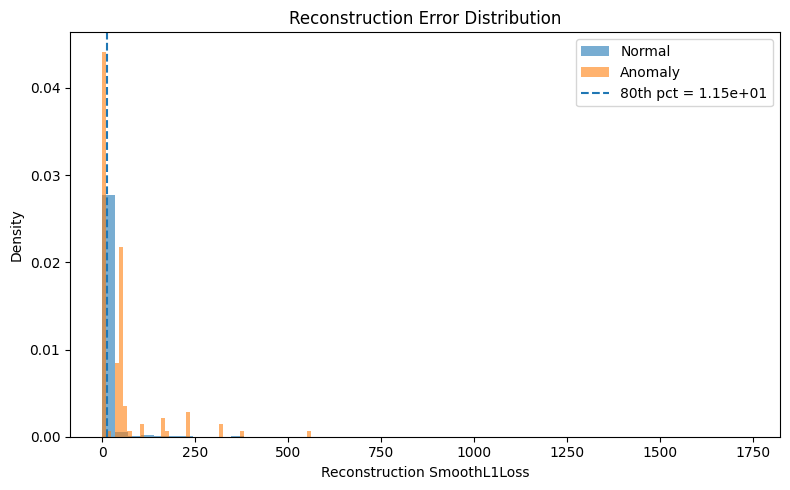

In [254]:
threshold = np.percentile(error_test, THRESHOLD)
plt.figure(figsize=(8,5))
plt.hist(error_test,bins=50, alpha=0.6, label="Normal", density=True)
plt.hist(error_anomalous, bins=50, alpha=0.6, label="Anomaly",  density=True)
plt.axvline(threshold, linestyle="--", label=f"80th pct = {threshold:.2e}")
plt.xlabel("Reconstruction SmoothL1Loss")
plt.ylabel("Density")
plt.title("Reconstruction Error Distribution")
plt.legend()
plt.tight_layout()
plt.show()

In [255]:
test_preds = (error_test > threshold).astype(int)
anomaly_preds = (error_anomalous > threshold).astype(int)
y_true_np = np.concatenate([np.zeros_like(error_test), np.ones_like(error_anomalous)]).astype(int)
y_pred_np = np.concatenate([test_preds, anomaly_preds])
print(confusion_matrix(y_true_np, y_pred_np))

[[75898  3995]
 [   63    64]]


In [256]:
print(classification_report(y_true_np, y_pred_np, target_names=["Normal", "Anomaly"]))
error_test_tensor = torch.from_numpy(error_test)
error_anomalous_tensor = torch.from_numpy(error_anomalous)
scores = torch.cat([error_test_tensor, error_anomalous_tensor]).numpy()
labels = np.concatenate([np.zeros(len(error_test)), np.ones(len(error_anomalous))])
fpr, tpr, _ = roc_curve(labels, scores)
precision, recall, _ = precision_recall_curve(labels, scores)
print("AUC (ROC):", auc(fpr, tpr))

              precision    recall  f1-score   support

      Normal       1.00      0.95      0.97     79893
     Anomaly       0.02      0.50      0.03       127

    accuracy                           0.95     80020
   macro avg       0.51      0.73      0.50     80020
weighted avg       1.00      0.95      0.97     80020

AUC (ROC): 0.8064568841139985


In [257]:
torch.save(model_ae_custom.state_dict(), 'EdgeBaselineModelAE.pth')
print("Anomaly Autoencoder model saved to 'EdgeBaselineModelAE.pth'")

model_ae_custom2 = AnomalyAutoencoder(input_dim=105, latent_dim=16).to(device)
model_ae_custom2.load_state_dict(torch.load('EdgeBaselineModelAE.pth'))
model_ae_custom2.eval()

Anomaly Autoencoder model saved to 'EdgeBaselineModelAE.pth'


AnomalyAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=105, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=64, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=25

In [258]:

# --- Edge Deployment Evidence ---

# 1. Model File Size
model_file_path = 'EdgeBaselineModelAE.pth'
model_file_size_bytes = os.path.getsize(model_file_path)
model_file_size_mb = model_file_size_bytes / (1024 * 1024)
print(f"\nModel File Size: {model_file_size_mb:.4f} MB")

# 2. Inference Time Profiling
sample_size = 1000
sample_data = test_tensor[:sample_size].to(device).float()

# Load model
model_ae_custom_read = AnomalyAutoencoder(input_dim=105, latent_dim=16).to(device)
model_ae_custom_read.load_state_dict(torch.load('EdgeBaselineModelAE.pth'))

# Measure inference time + Inference time per sample
model_ae_custom.eval()
start_time = time.time()
with torch.no_grad():
    reconstructed_sample = model_ae_custom_read(sample_data)
    sample_errors = ((sample_data - reconstructed_sample)**2).mean(dim=1).cpu().numpy()
end_time = time.time()
inference_time_seconds = end_time - start_time
inference_time_per_sample_ms = (inference_time_seconds / sample_size) * 1000

print(f"\nInference Time Profiling (Sample Size: {sample_size}):")
print(f"Total inference time for {sample_size} samples: {inference_time_seconds:.4f} seconds")
print(f"Average inference time per sample: {inference_time_per_sample_ms:.4f} ms")


Model File Size: 0.5351 MB

Inference Time Profiling (Sample Size: 1000):
Total inference time for 1000 samples: 0.0014 seconds
Average inference time per sample: 0.0014 ms


In [176]:
print("\nSystem Resource Usage (General):")
print(f"CPU Usage: {psutil.cpu_percent()}%")
print(f"Memory Usage: {psutil.virtual_memory().percent}%")

if torch.cuda.is_available():
    !nvidia-smi



System Resource Usage (General):
CPU Usage: 35.8%
Memory Usage: 65.6%
Mon Jun 16 16:46:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P0             27W /   70W |    8396MiB /  15360MiB |      0%      Default |
|                                         |                        | 

# Appendix

- [Hard Drive Dataset](https://www.backblaze.com/cloud-storage/resources/hard-drive-test-data)